In [11]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Flatten, MaxPooling2D, Input, BatchNormalization, Dropout, Dense

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
 tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
train_path = 'train'
validation_path = 'val'
test_path = 'test'

train_datagen = ImageDataGenerator(
    rescale = 1 / 255.0,
    rotation_range = 10,
    zoom_range = 0.1,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1 / 255.0
)

train_gen = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (48,48),
    color_mode = 'grayscale',
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42
)

validation_gen = test_datagen.flow_from_directory(
    directory = validation_path,
    target_size = (48,48),
    color_mode = 'grayscale',
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42
)

test_gen = test_datagen.flow_from_directory(
    directory = test_path,
    target_size = (48,48),
    color_mode = 'grayscale',
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [25]:
# model definition

input = Input(shape = (48,48,1))
x = Conv2D(filters=256,kernel_size=3,activation='relu',padding='same')(input)

x = Conv2D(filters=512,kernel_size=3,activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

x = Conv2D(filters=384,kernel_size=3,activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

x = Conv2D(filters=192,kernel_size=3,activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

x = Conv2D(filters=384,kernel_size=3,activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.4)(x)

x = Flatten()(x)

x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)

x = Dropout(0.3)(x)
x = Dense(7,activation='softmax')(x)

model = Model(input, x)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 48, 48, 256)       2560      
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 512)       1180160   
                                                                 
 batch_normalization_15 (Bat  (None, 48, 48, 512)      2048      
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 512)      0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 24, 24, 512)       0   

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience = 4, verbose = 1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience = 20, verbose = 1)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss = tf.keras.losses.categorical_crossentropy, metrics = 'acc', optimizer = optimizer)
history = model.fit(train_gen,validation_data = validation_gen, epochs = 150, callbacks = [early_stopping])

Epoch 1/150
449/449 [==============================] - 464s 1s/step - loss: 2.0003 - acc: 0.2513 - val_loss: 1.8293 - val_acc: 0.2934
Epoch 2/150
449/449 [==============================] - 110s 246ms/step - loss: 1.6631 - acc: 0.3558 - val_loss: 1.4910 - val_acc: 0.4218
Epoch 3/150
449/449 [==============================] - 110s 246ms/step - loss: 1.4533 - acc: 0.4397 - val_loss: 1.6014 - val_acc: 0.4255
Epoch 4/150
449/449 [==============================] - 111s 246ms/step - loss: 1.3327 - acc: 0.4905 - val_loss: 1.2612 - val_acc: 0.5222
Epoch 5/150
449/449 [==============================] - 111s 247ms/step - loss: 1.2634 - acc: 0.5192 - val_loss: 1.2171 - val_acc: 0.5380
Epoch 6/150
449/449 [==============================] - 111s 246ms/step - loss: 1.2186 - acc: 0.5340 - val_loss: 1.1893 - val_acc: 0.5634
Epoch 7/150
449/449 [==============================] - 111s 247ms/step - loss: 1.1965 - acc: 0.5438 - val_loss: 1.1835 - val_acc: 0.5561
Epoch 8/150
449/449 [=======================

In [27]:
model.evaluate(test_gen, verbose=1)

57/57 [==============================] - 42s 743ms/step - loss: 0.8969 - acc: 0.6879


[0.8969002962112427, 0.6879353523254395]

In [29]:
!pip install matplotlib

In [30]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


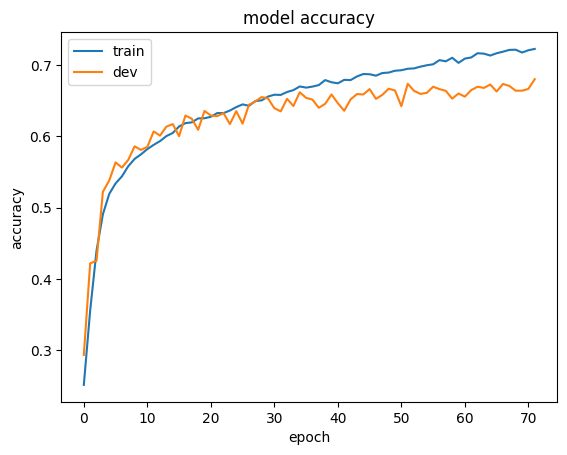

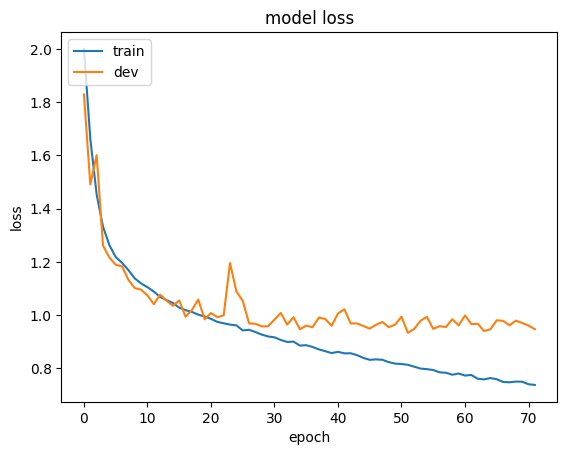

In [31]:
# list all data in history
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [32]:
model.save('models/CNN_69%_72epsES.h5')